<a href="https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchIO: a tutorial

In this tutorial, we will train a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) to perform brain segmentation from T1-weighted MRI using the [Information eXtraction from Images (IXI) dataset](https://brain-development.org/ixi-dataset/), a publicly available dataset of almost 600 subjects.

## Setup

In [1]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

Install some PyPI packages:

In [2]:
!pip install --quiet --upgrade pip
!pip install --quiet unet==0.7.7
!pip install --quiet torchio==0.18.48
!apt -qq install tree

     |████████████████████████████████| 1.6 MB 5.3 MB/s 
     |████████████████████████████████| 151 kB 5.2 MB/s 
     |████████████████████████████████| 48.4 MB 32 kB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Selecting previously unselected package tree.
(Reading database ... 148489 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Import modules:

In [28]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Tue Aug 31 10:35:40 2021
TorchIO version: 0.18.48


## Data

### Dataset

I downloaded the [IXI](https://brain-development.org/ixi-dataset/) dataset, segmented all brains using [ROBEX](https://ieeexplore.ieee.org/document/5742706), affine-registered everything to an MNI template with [NiftyReg](https://github.com/KCL-BMEIS/niftyreg), resampled everything into a space with a very large voxel spacing and funny orientation with [ITK](https://itk.org/) and uploaded a zip file to Dropbox.
It will be our medical-images MNIST dataset.

It can also be instantiated directly using [`torchio.datasets.IXITiny`](https://torchio.readthedocs.io/datasets.html#ixitiny), but we will do everything manually here.

In [4]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=0'
dataset_path = 'ixi_tiny.zip'
dataset_dir_name = 'ixi_tiny'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [5]:
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

ixi_tiny
├── image
└── label

2 directories


### [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html)

This is one of the most important classes in the library. It inherits from `torch.utils.data.Dataset`. It receives as input a list of [`torchio.Subject`](https://torchio.readthedocs.io/data/subject.html#subject) instances and an optional [`torchio.transforms.Transform`](https://torchio.readthedocs.io/transforms/transforms.html#torchio.transforms.Transform). 

The inputs to the subject class are instances of `torchio.Image`, such as [`torchio.ScalarImage`](https://torchio.readthedocs.io/data/image.html#scalarimage) or [`torchio.LabelMap`](https://torchio.readthedocs.io/data/image.html#labelmap). The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

In [6]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


Let's take a look at one of the subjects in the dataset.

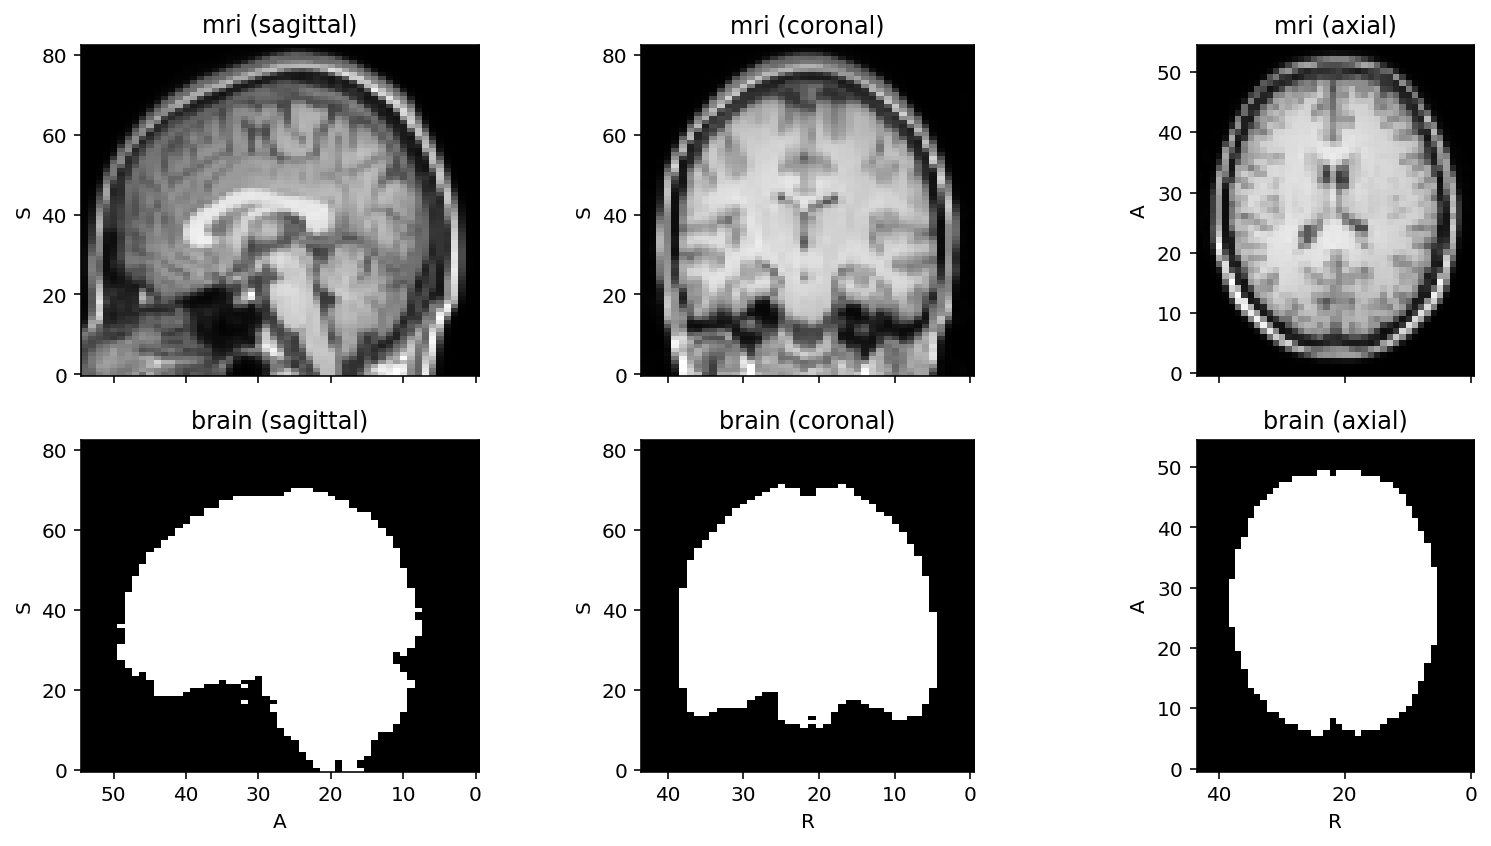

In [7]:
one_subject = dataset[0]
one_subject.plot()

In [8]:
print(one_subject)
print(one_subject.mri)
print(one_subject.brain)

Subject(Keys: ('mri', 'brain'); images: 2)
ScalarImage(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 392.3 KiB; dtype: torch.ShortTensor)
LabelMap(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 196.2 KiB; dtype: torch.ByteTensor)


## [Transforms](https://torchio.readthedocs.io/transforms/transforms.html#transforms)

For a full tutorial on TorchIO transforms, check out our [Data preprocessing and augmentation using TorchIO](https://github.com/fepegar/torchio/blob/master/examples/README.md) tutorial.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/fepegar/torchio/blob/master/examples/README.md)

#### Normalization

We will use the [`HistogramStandardization`](https://torchio.readthedocs.io/transforms/preprocessing.html#histogramstandardization) and the [`ZNormalization`](https://torchio.readthedocs.io/transforms/preprocessing.html#znormalization) transforms to normalize our images intensity.

The images have been acquired by different MRI scanners at different hospitals. We will apply some normalization techniques so that intensities are similarly distributed and within similar ranges.

Training the histogram is typically quite fast. It takes long here because of the fancy plotting.

  0%|          | 0/566 [00:00<?, ?it/s]

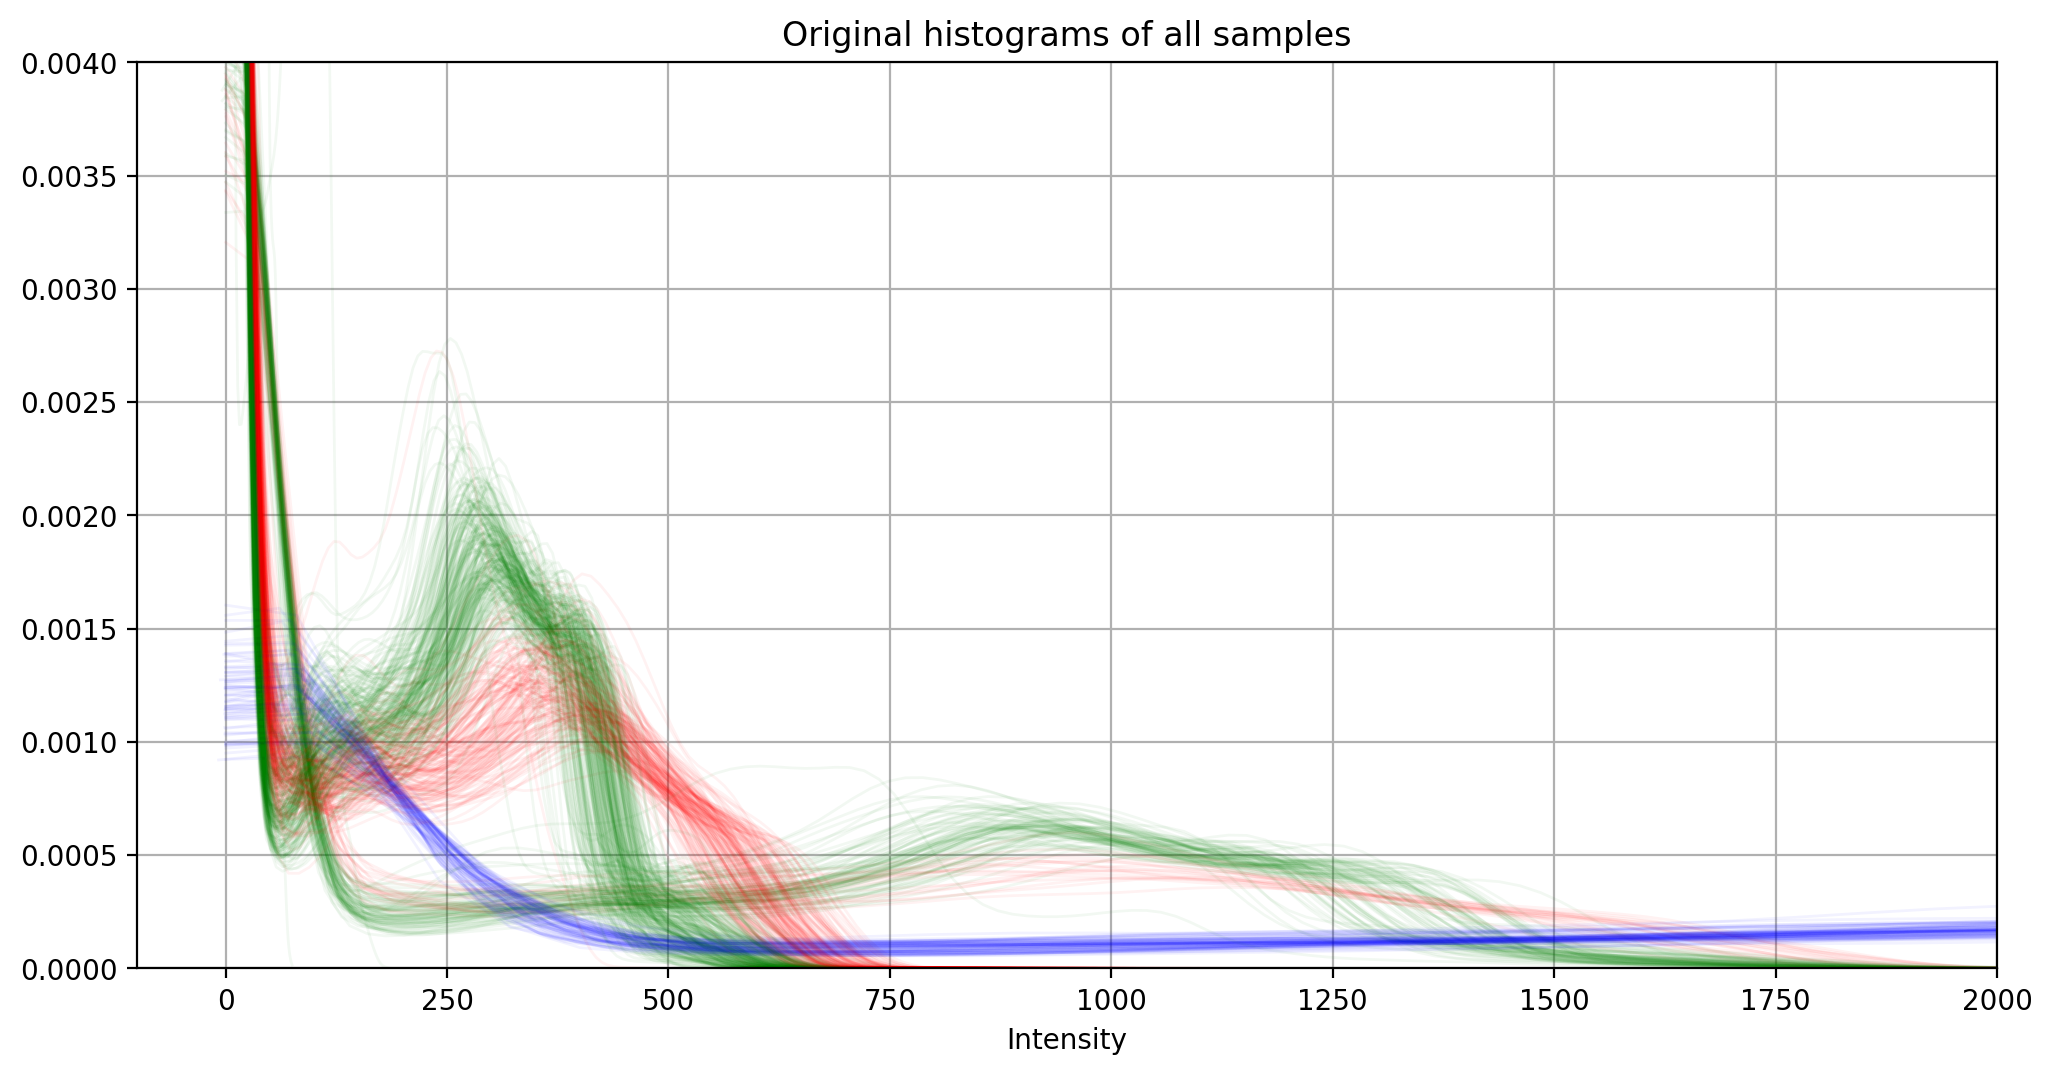

In [9]:
paths = image_paths

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for path in tqdm(paths):
        tensor = tio.ScalarImage(path).data
        if 'HH' in path.name: color = 'red'
        elif 'Guys' in path.name: color = 'green'
        elif 'IOP' in path.name: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004);
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/daqsg3udk61v65i/hist_original.png?dl=1')
graph

In [10]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 566/566 [00:06<00:00, 87.13it/s] 


Trained landmarks: [ -0.      0.002   0.108   0.227   0.467   2.014  15.205  34.297  49.664
  55.569  61.178  74.005 100.   ]


  0%|          | 0/566 [00:00<?, ?it/s]

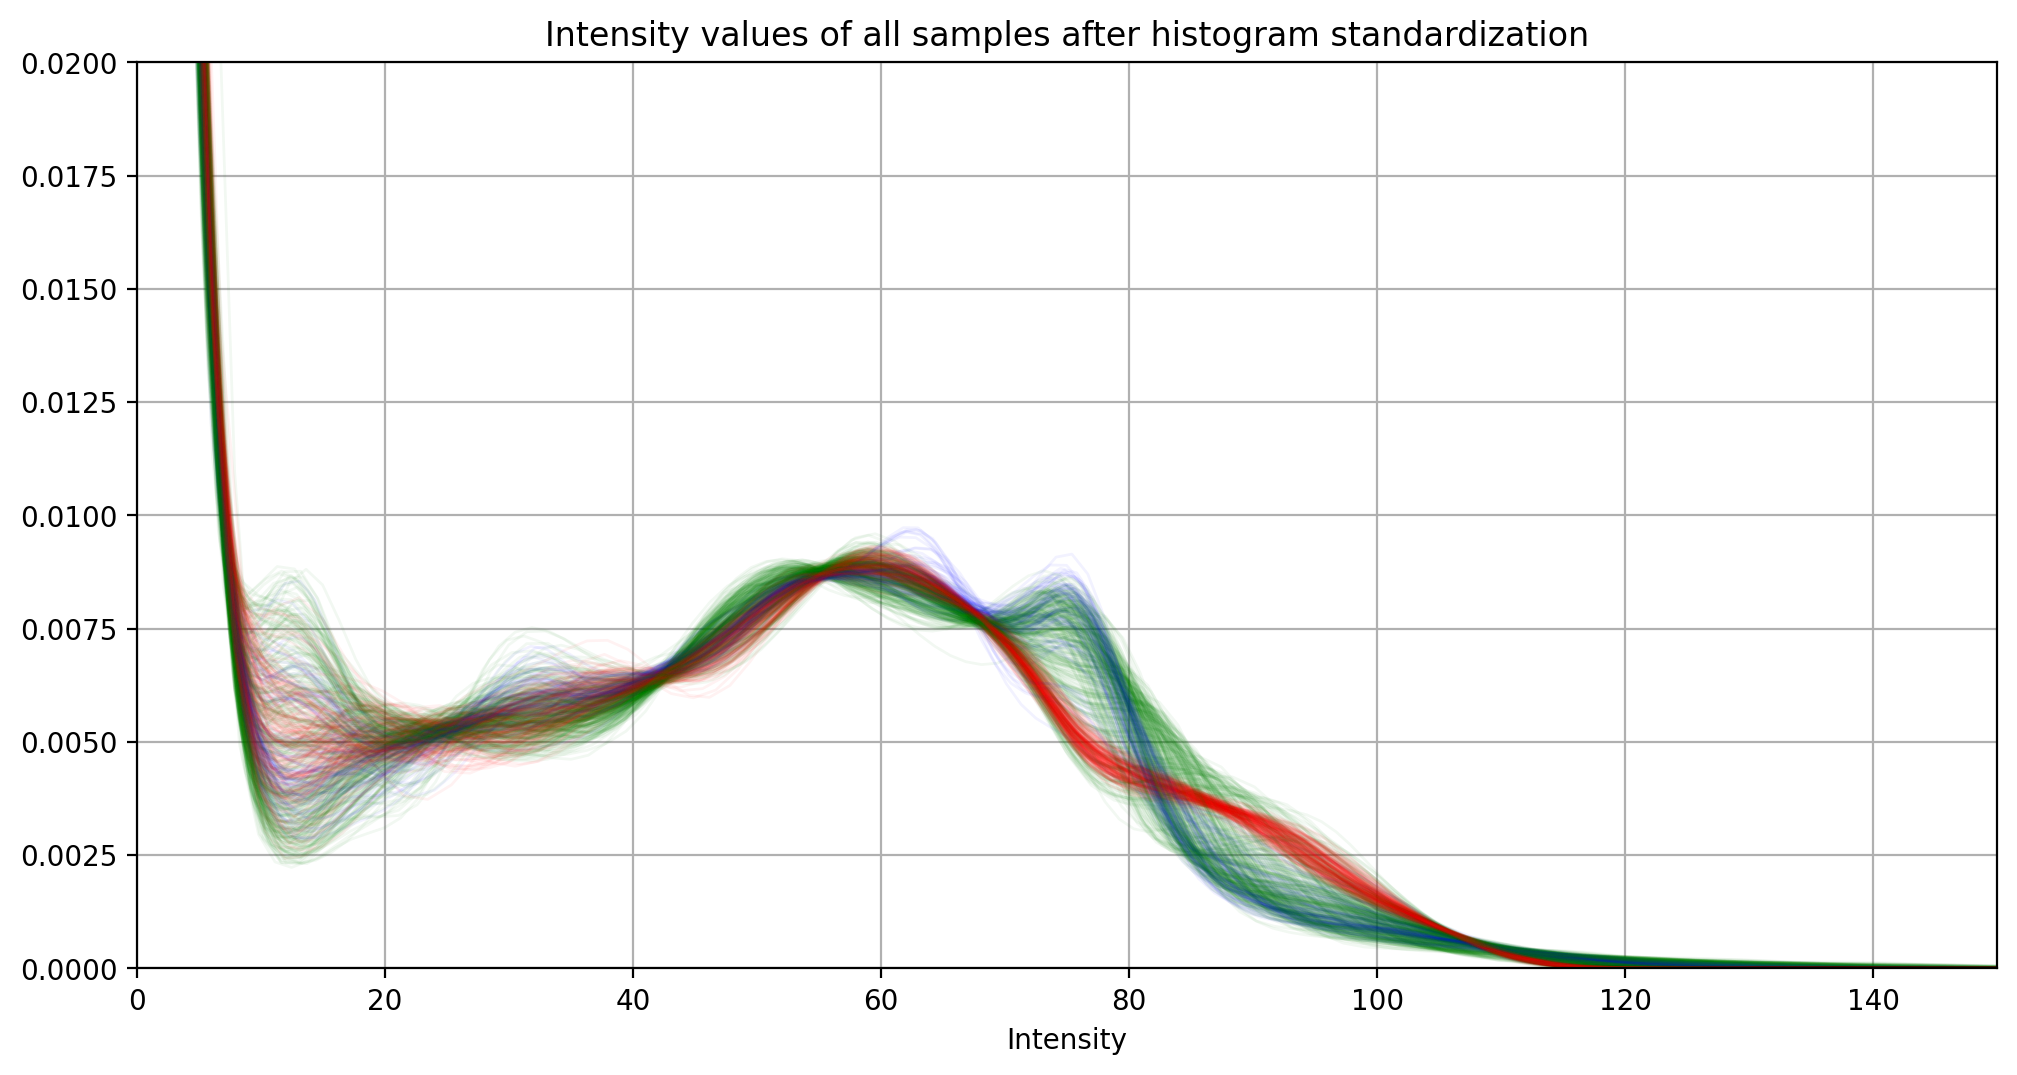

In [11]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i ,sample in enumerate(tqdm(dataset)):
        standard = histogram_transform(sample)
        tensor = standard.mri.data
        path = str(sample.mri.path)
        if 'HH' in path: color = 'red'
        elif 'Guys' in path: color = 'green'
        elif 'IOP' in path: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 0.02)
    ax.set_title('Intensity values of all samples after histogram standardization')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/dqqaf78c86mrsgn/hist_standard.png?dl=1')
graph

Z-standardization or normalization means that our output data will have zero mean and unit variance. We do this using means and variances computed for each image, as opposed to the whole dataset, as MRI values can vary a lot.

In this example, we use only foreground values to compute the mean and variance. The foreground is approximated as all values above the mean, which typically works well.

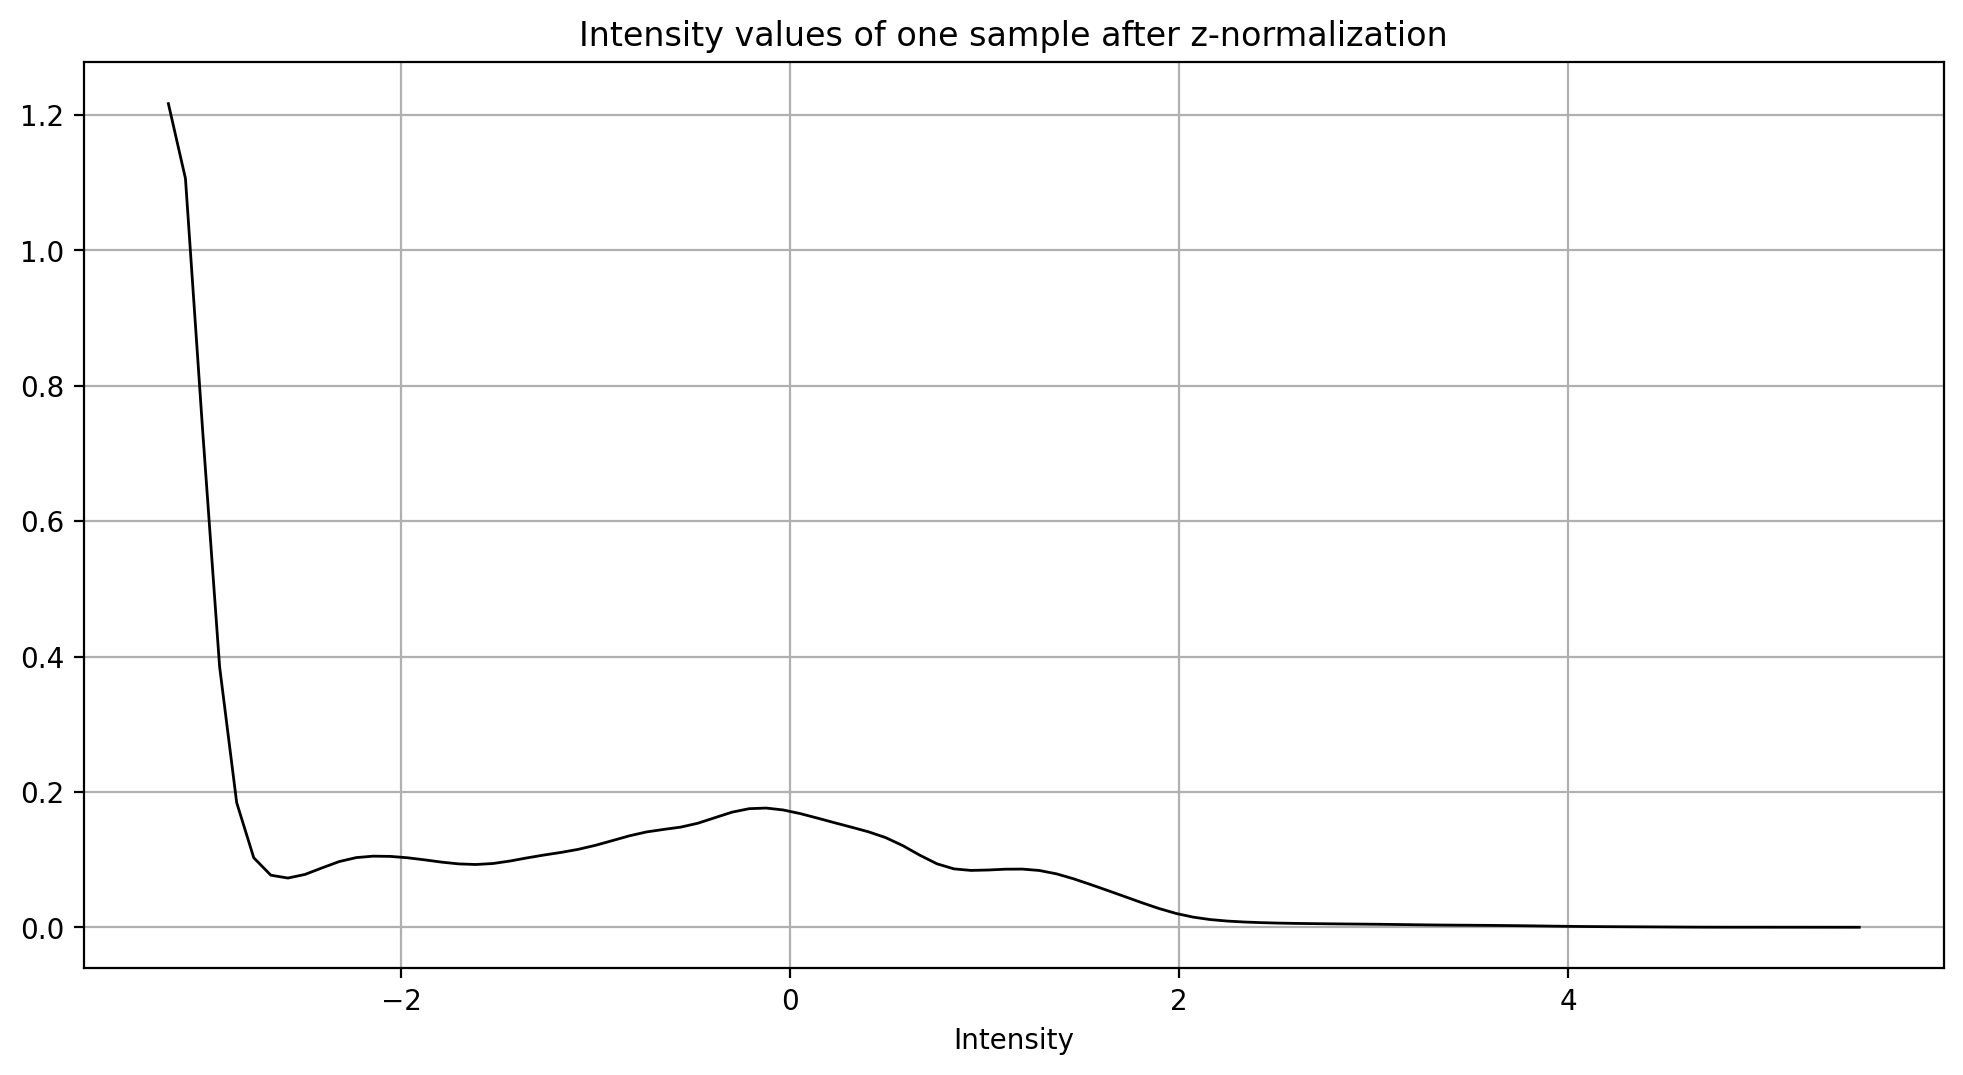

In [12]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.mri.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()

## Training a network



In [13]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 57 subjects


### Deep learning stuff

In [14]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    targets = batch['brain'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

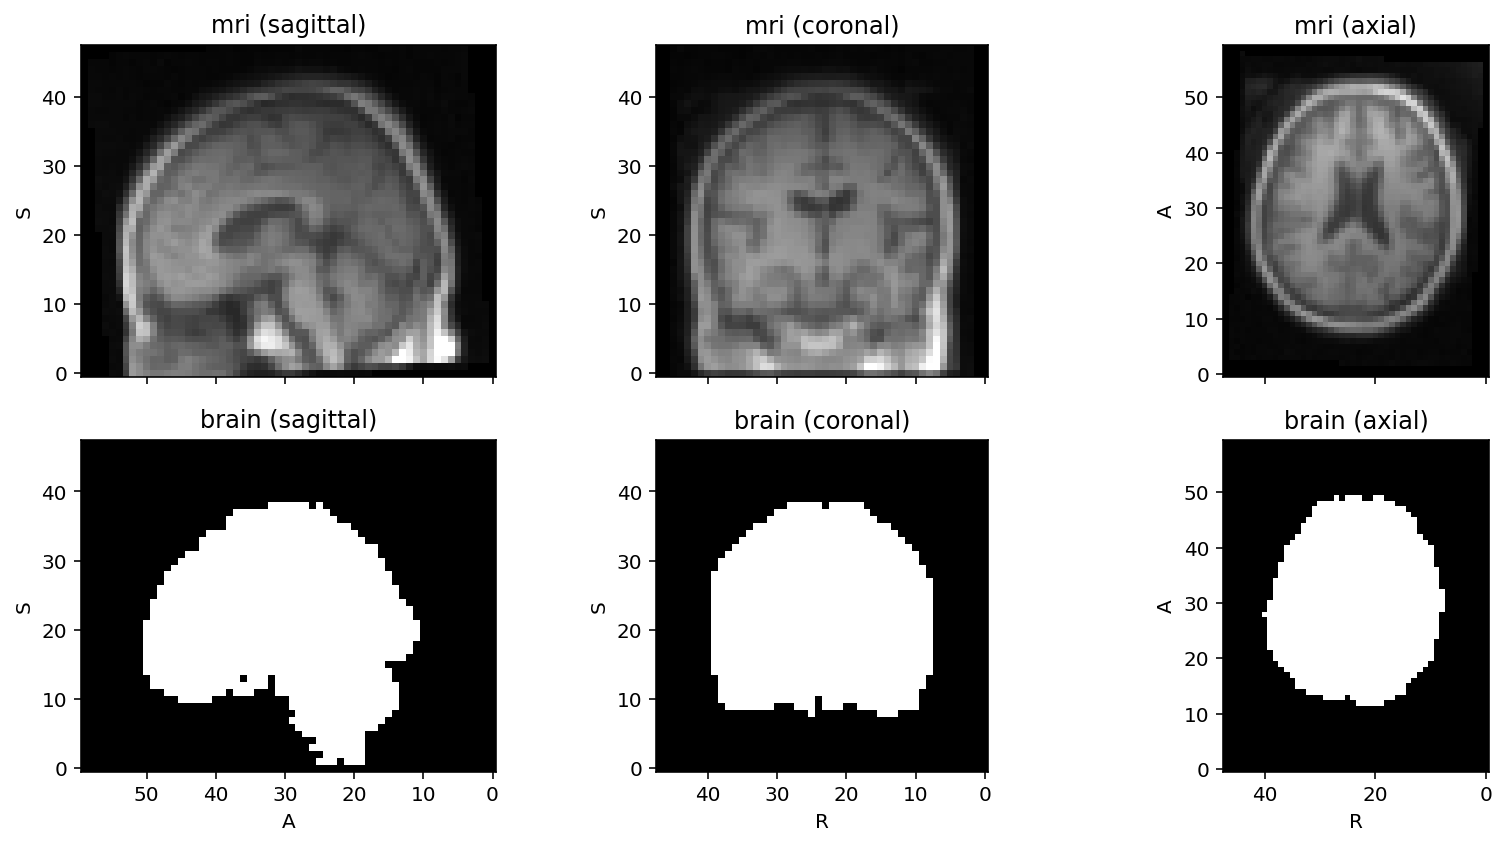

In [15]:
training_instance = training_set[42]  # transform is applied inside SubjectsDataset
training_instance.plot()

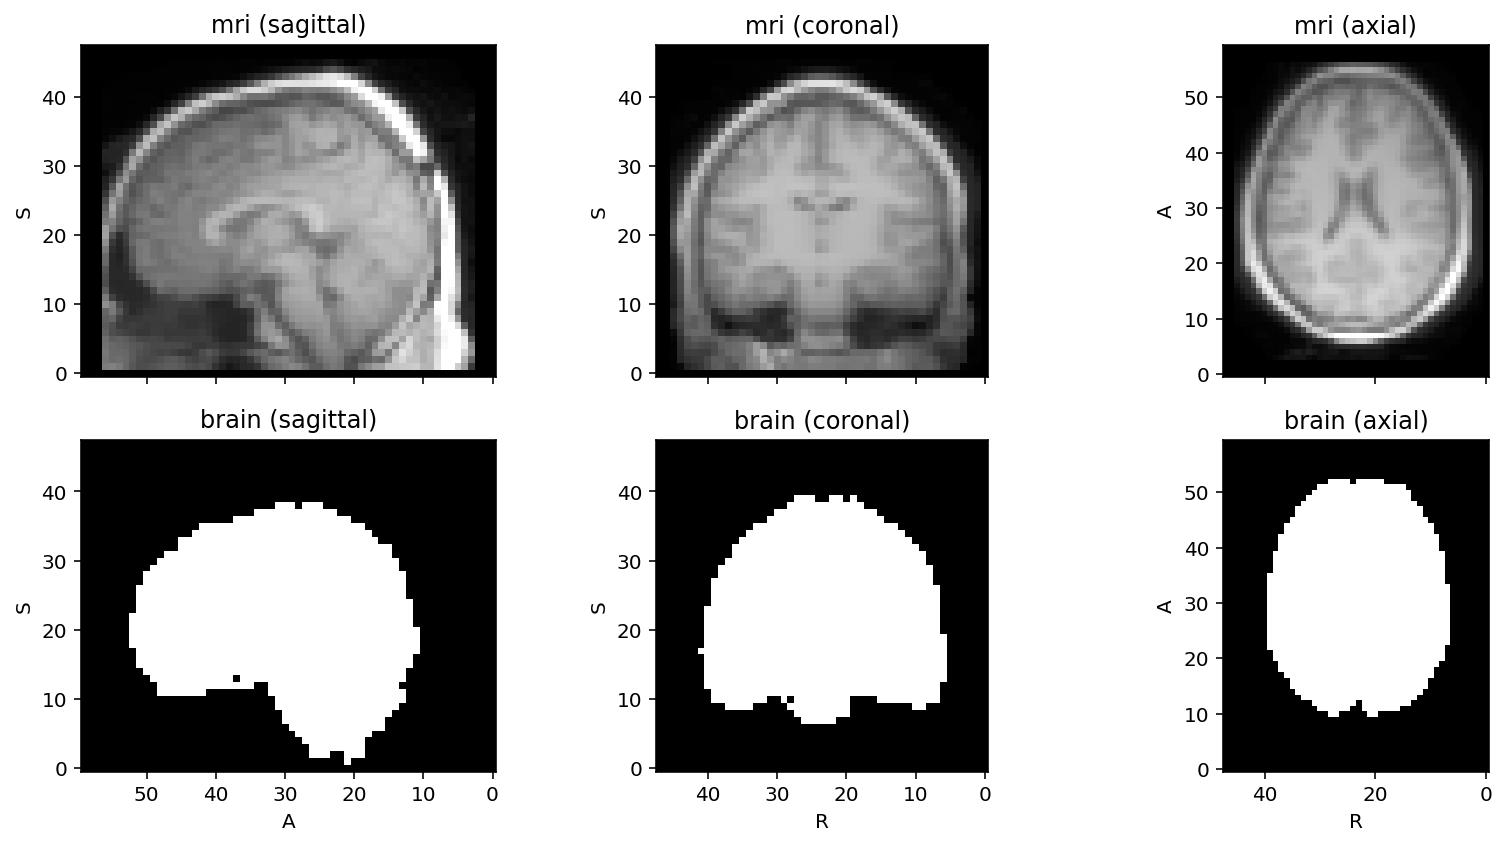

In [16]:
validation_instance = validation_set[42]
validation_instance.plot()

### Whole images

In [17]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

Visualize axial slices of one batch

In [18]:
one_batch = next(iter(training_loader))

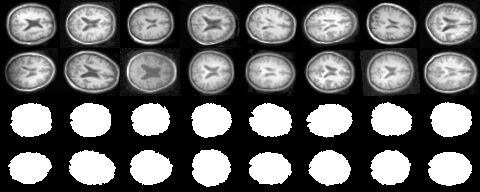

In [19]:
k = 24
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size//2,
    normalize=True,
    scale_each=True,
    padding=0,
)
display.Image(image_path)

#### Train

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Validation mean loss: 0.537
Starting epoch 1


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.271


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.217
Starting epoch 2


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.171


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.134
Starting epoch 3


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.117


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.103
Starting epoch 4


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.084


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.074
Starting epoch 5


  0%|          | 0/32 [00:00<?, ?it/s]

Training mean loss: 0.064


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.057


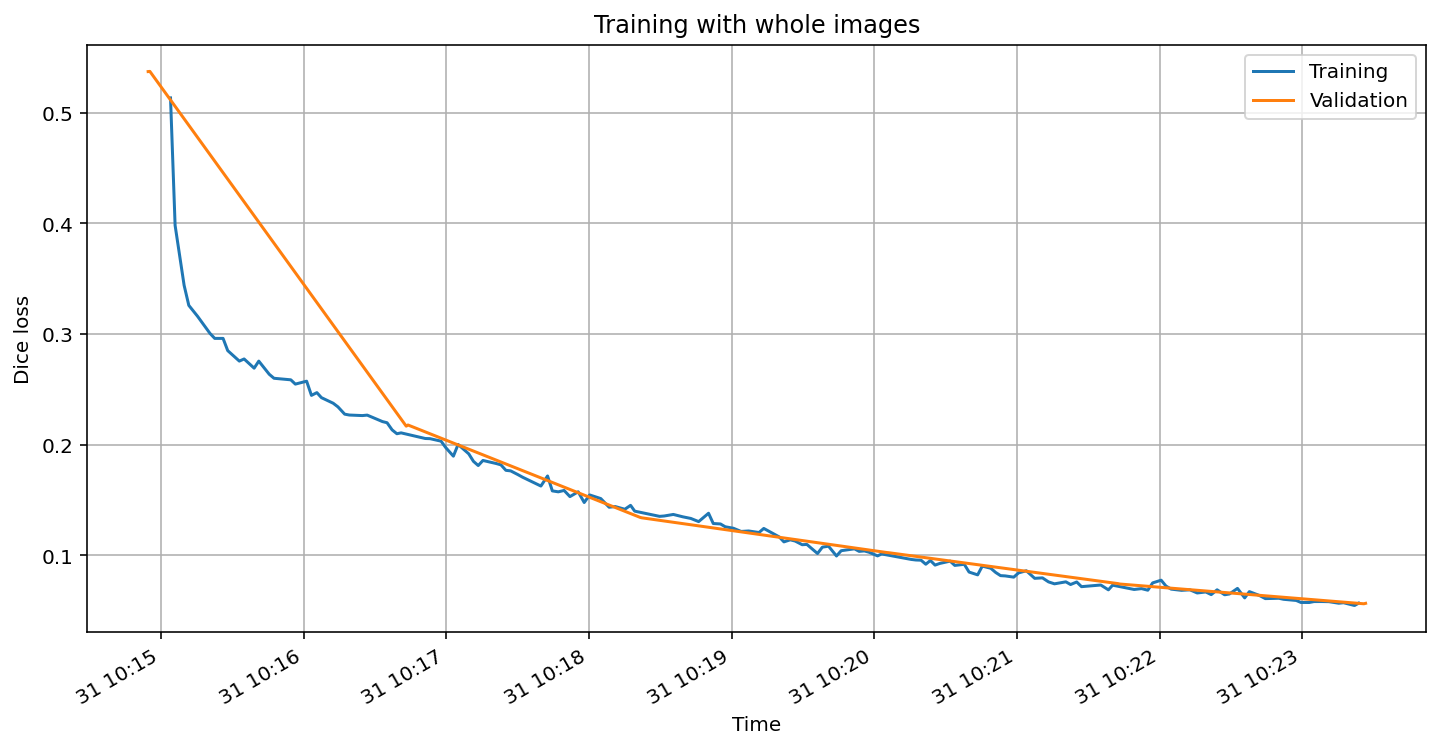

In [20]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/whole_images_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

#### Test

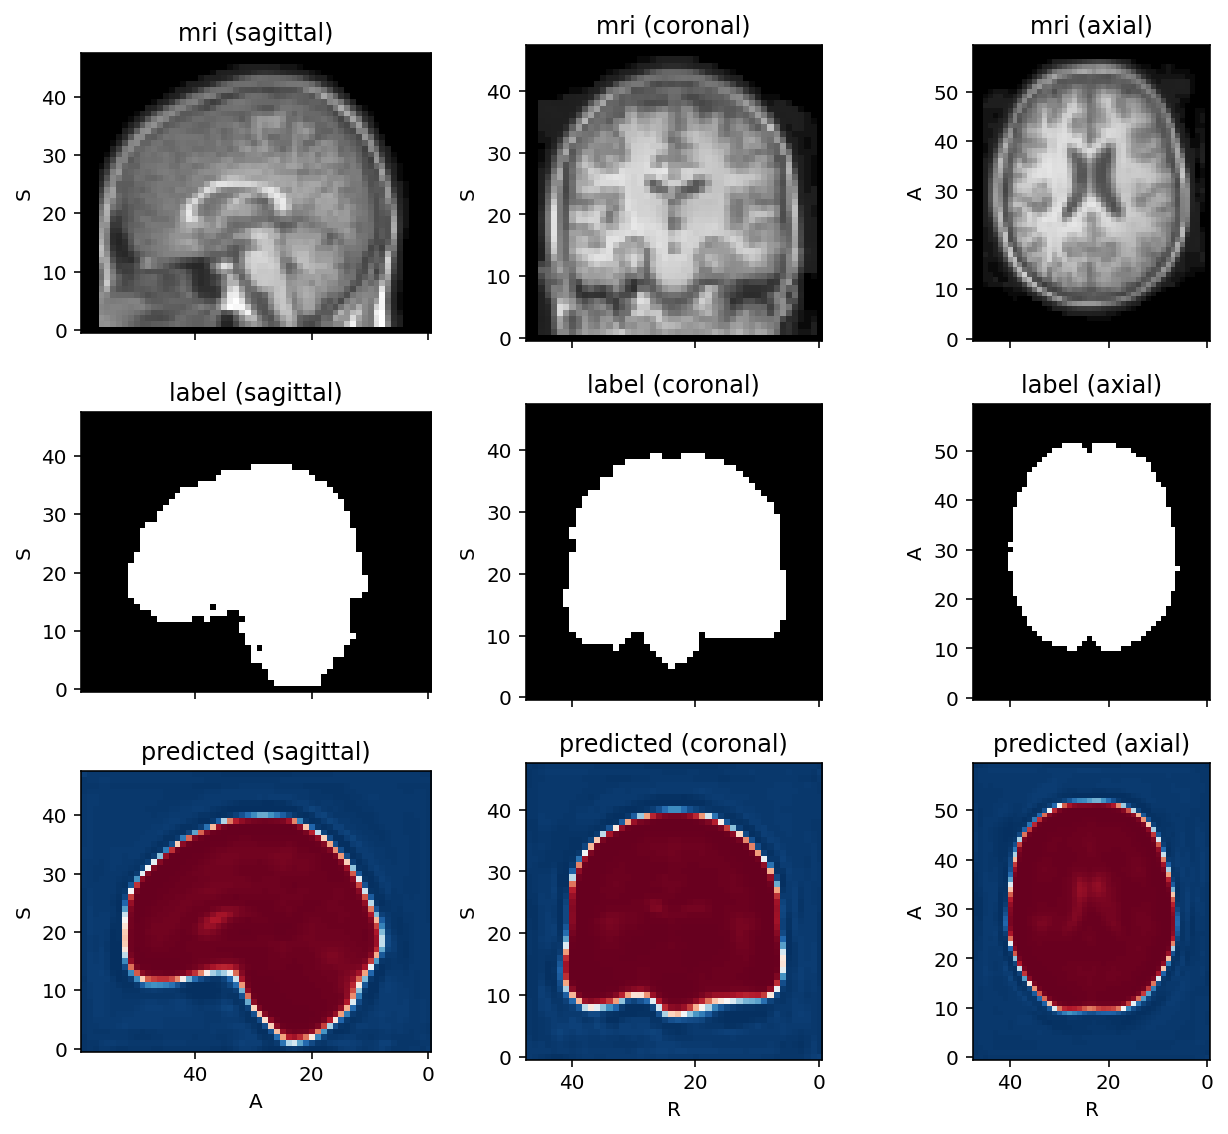

In [21]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['brain'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

### Patch-based

Recommended read: [Patch-based pipelines](https://torchio.readthedocs.io/data/patch_based.html).



In [22]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size

patch_size = 24
samples_per_volume = 5
max_queue_length = 300
sampler = tio.data.UniformSampler(patch_size)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Visualize axial slices of one batch

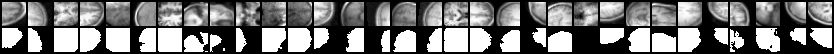

In [23]:
one_batch = next(iter(training_loader_patches))
k = int(patch_size // 4)
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

#### Train

  0%|          | 0/5 [00:00<?, ?it/s]

Validation mean loss: 0.528
Starting epoch 1


  0%|          | 0/80 [00:00<?, ?it/s]

Training mean loss: 0.229


  0%|          | 0/5 [00:00<?, ?it/s]

Validation mean loss: 0.145
Starting epoch 2


  0%|          | 0/80 [00:00<?, ?it/s]

Training mean loss: 0.107


  0%|          | 0/5 [00:00<?, ?it/s]

Validation mean loss: 0.064
Starting epoch 3


  0%|          | 0/80 [00:00<?, ?it/s]

Training mean loss: 0.075


  0%|          | 0/5 [00:00<?, ?it/s]

Validation mean loss: 0.050
Starting epoch 4


  0%|          | 0/80 [00:00<?, ?it/s]

Training mean loss: 0.055


  0%|          | 0/5 [00:00<?, ?it/s]

Validation mean loss: 0.041
Starting epoch 5


  0%|          | 0/80 [00:00<?, ?it/s]

Training mean loss: 0.049


  0%|          | 0/5 [00:00<?, ?it/s]

Validation mean loss: 0.039


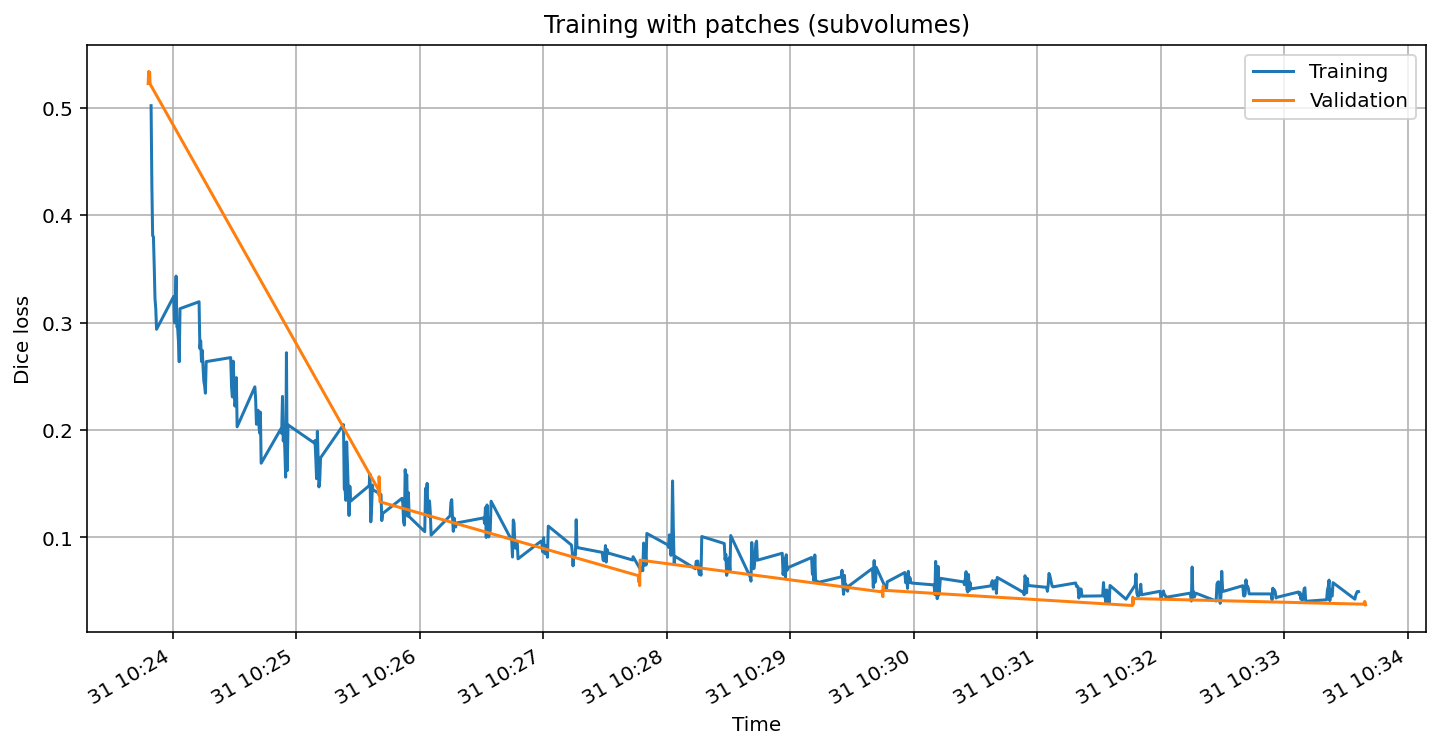

In [24]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'patches_state_dict.pth'

if train_patches:
    weights_stem = 'patches'
    train_losses, val_losses = train(
        num_epochs,
        training_loader_patches,
        validation_loader_patches,
        model,
        optimizer,
        weights_stem,
    )
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/patches_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with patches (subvolumes)')
ax.legend()
fig.autofmt_xdate()

#### Test

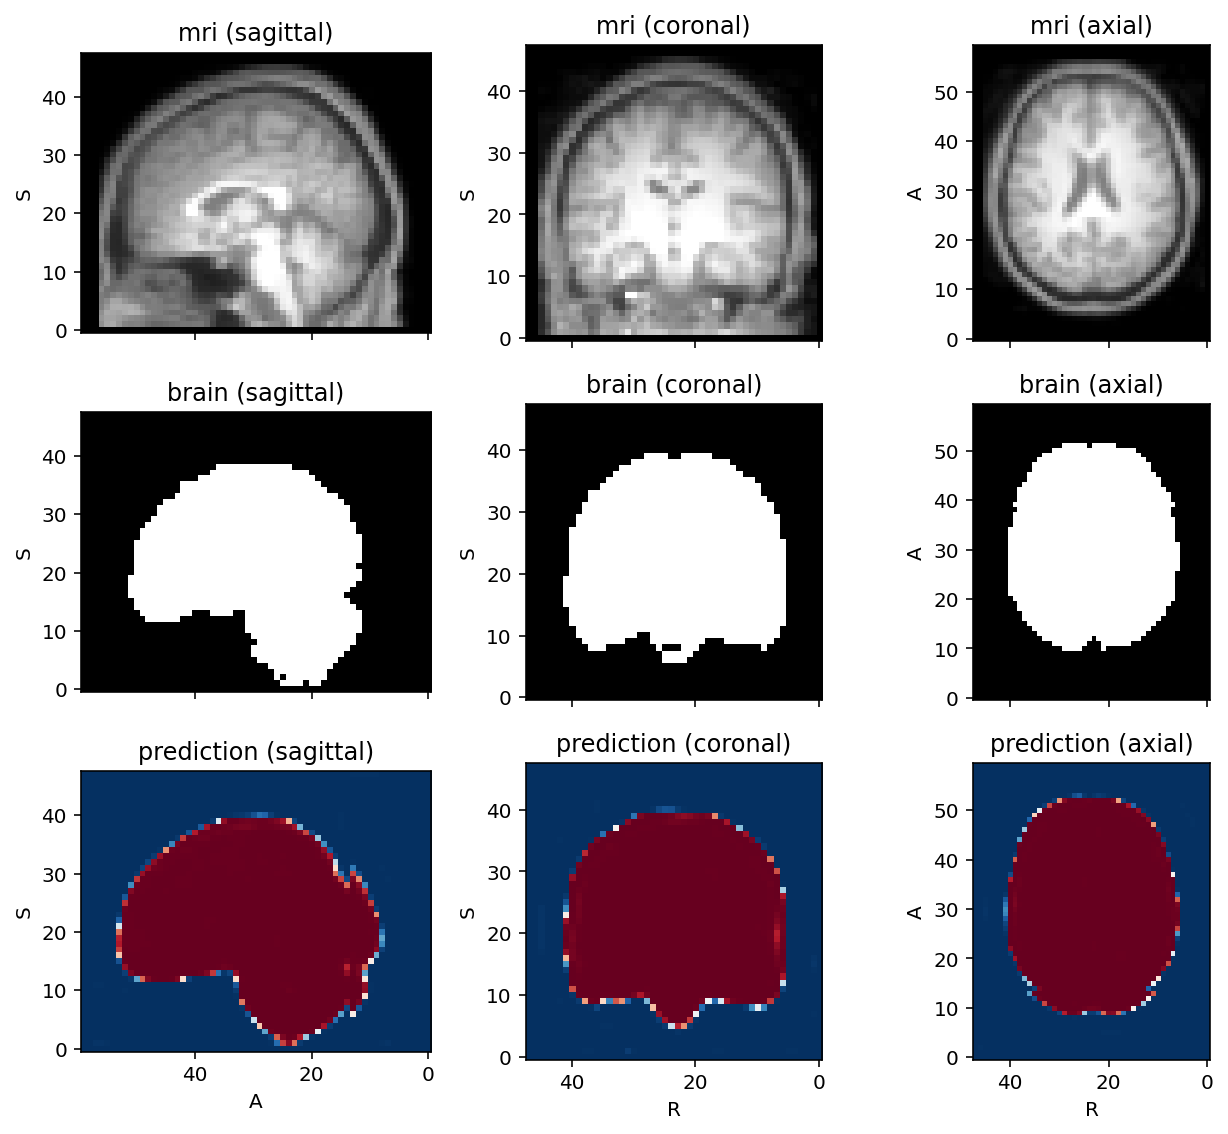

In [25]:
subject = random.choice(validation_set)
input_tensor = sample.mri.data[0]
patch_size = 48, 48, 48  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['mri'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        probabilities = model(inputs).softmax(dim=CHANNELS_DIMENSION)
        aggregator.add_batch(probabilities, locations)

foreground = aggregator.get_output_tensor()
affine = subject.mri.affine
prediction = tio.ScalarImage(tensor=foreground, affine=affine)
subject.add_image(prediction, 'prediction')
subject.plot(figsize=(9, 8), cmap_dict={'prediction': 'RdBu_r'})

## Conclusion

By now, you should be able to code your own training and evaluation pipeline using TorchIO to process your images before and after feeding them to the network.

If you want to learn more, make sure you check [all the notebooks](https://github.com/fepegar/torchio/tree/master/examples).

If you like TorchIO, please star [the repository](https://github.com/fepegar/torchio) and tell all your friends about it!

And if you use TorchIO for your research, please [cite our paper](https://torchio.readthedocs.io/#credits).